# Create tiled subset split csv files

This Jupyter Notebook can be used to divide the merged .tif file (created by *04_merge_tifs.sh* with argument _TRAIN_) into tiles of variable tilesize. Next, the tiles are randomly (although with fixed random seed for repeatability) split into 3 subsets *train*, *test* and *validation* and saved as .csv files.


**Table of Contents**

+ [1. Set variables and dictionaries](#1.-Set-variables-and-dictionaries)
+ [2. Helper functions](#2.-Helper-functions)
+ [3. Create tiled subset split](#3.-Create-tiled-subset-split)
+ [4. Visualisation: plot subset split map](#4.-Visualisation:-plot-subset-split-map)


***
### packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


***

## 1. Set variables and dictionaries

In [2]:
# variables:

# name of the parameter that has been added to the sentinel bands ( = last band in *_merged.tif )
parameter = 'BOART_N'
# define the size of the quadratic tiles, shape will be (tile_size, tile_size, nr_bands+1)
tile_size = 16
# gap, i.e. number of pixel to lie between neighbouring tiles
tile_sep = 2
# processing level of the sentinel-2 image
level = 'L2A'
# date of the sentinel-2 image
date = '20161206'

# fraction of pixel used to generate train tiles
train_frac = 0.6
# fraction of pixel used to generate validation tiles
valid_frac = 0.2
# remaining fraction ( = 1 - train_frac - valid_frac) will be fraction of test tiles

***

## 2. Helper functions

In [3]:
def get_tile_nrs_from_df(df):
    """
    Get a DataFrame containing only rows of unique (row_nr, col_nr) pairs of a MultiIndex DataFrame.
    
    Basically build a new df containing only the 'row_nr' and 'col_nr'.
    """
    
    # df.xs() allows to index by a certain index level
    # reduces the data to the first pixel of every tile,
    # therefore every row has a unique (row_nr, col_nr) pair
    
    return pd.DataFrame(data={'row_nr': df.xs(0, level='pixel_nr').index.get_level_values(0),
                              'col_nr': df.xs(0, level='pixel_nr').index.get_level_values(1)})


def make_split_df(full_tile_df, df_tile_nrs):
    """
    Get a split of the MultiIndex DataFrame with all tiles by passing a DataFrame 
    containing all the (row_nr, col_nr) pairs of the desired split as data.
    """
    tile_index_list = list(zip(df_tile_nrs['row_nr'].to_list(), df_tile_nrs['col_nr'].to_list()))
    
    train_indices = []
    for tile_nrs in tile_index_list:
        for i in range(tile_size**2):
            train_indices.append((tile_nrs[0], tile_nrs[1], i))

    split_df = full_tile_df.loc[train_indices, :]
    
    return split_df

***

## 3. Create tiled subset split

### 3.1. Pandas DataFrame

In [4]:
# read tif
data = imread(f'data/training_data/{date}_data/{date}_{level}_merged.tif')
height, width = data.shape[0], data.shape[1]

if level == 'L1C':
    bands = ["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10", "b11", "b12", "b8a"]
else:
    bands = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b11', 'b12', 'b8a', 'AOT', 'WVP', 'CLD', 'SCL', 'SNW']

tuples = ()

index = pd.MultiIndex.from_tuples(tuples, names=['row_nr', 'col_nr', 'pixel_nr'])

full_tile_df = pd.DataFrame(index=index, columns=bands+[parameter])

nr_tile_rows = height // (tile_size+tile_sep)
nr_tile_cols = width // (tile_size+tile_sep)

for i in range(nr_tile_rows):
    for j in range(nr_tile_cols):
        # get a tile
        # tiles separated by "tile_sep" pixel
        tile = data[i*(tile_size+tile_sep):(i+1)*(tile_size+tile_sep)-tile_sep, 
                    j*(tile_size+tile_sep):(j+1)*(tile_size+tile_sep)-tile_sep, 
                    :]
        
        # exclude tiles that have pixel outside Sentinel-2 image area
        # or pixel outside area of shapefile
        if np.all(tile[:, :, len(bands)]) and np.all(tile[:, :, 0]):
            tile_flat = np.empty((tile_size**2, tile.shape[2]))
            for k in range(tile.shape[2]):
                tile_flat[..., k] = tile[..., k].flatten()

            iterables = [[i], [j], np.arange(tile_size**2)]
            tile_df = pd.DataFrame(data=tile_flat,
                                   columns=bands+[parameter],
                                   index=pd.MultiIndex.from_product(iterables, names=['row_nr', 'col_nr', 'pixel_nr'])
                                  )
            full_tile_df = full_tile_df.append(tile_df)

### 3.2. Optional: add new columns to DataFrame

In [5]:
# dict with names corresponding to each integer:
soil_texture_dict = {1: 'Sl3',
                     2: 'Slu',
                     3: 'Uls',
                     4: 'Sl4',
                     5: 'Lu',
                     6: 'Ls2',
                     7: 'Ls3',
                     8: 'Sl2',
                     9: 'Ha',
                     10: 'Ut2',
                     11: None}


# super_U: silt
# super_S: sand
# super_L: loam
# super_T: clay
superclass_dict = {1: 'super_U', 
                   2: 'super_S', 
                   3: 'super_L', 
                   4: 'super_T'}

superclass_dict_inv = {v: k for k, v in superclass_dict.items()}



def get_soil_texture_superclass(category_name):
    """Combine classes to superclasses."""
    
    if category_name in ["Uu", "Us", "Ut2", "Ut3", "Ut4", "Uls", "Lu"]:
        return "super_U"
    
    elif category_name in ["Tt", "Tl", "Ts2", "Tu2", "Tu3", "Tu4", "Lt3"]:
        return "super_T"
    
    elif category_name in ["Ss", "St2", "Su2", "Su3", "Su4", "Sl2",
                           "Sl3", "mSgs"]:
        return "super_S"
    
    elif category_name in ["Ls2", "Ls3", "Ls4", "Lt2", "Lts", "Ts3", "Ts4", "St3", "Sl4", "Slu"]:
        return "super_L"
    
    elif category_name == "Ha":
        return "Ha"
    else:
        print("Warning: Category {0} was not included into superclasses."
              .format(category_name))
        return category_name

In [6]:
# get superclasses
full_tile_df['BOART'] = full_tile_df['BOART_N'].map(soil_texture_dict)
full_tile_df['Soil_superclass'] = full_tile_df['BOART'].apply(get_soil_texture_superclass)
full_tile_df['Soil_superclass_N'] = full_tile_df['Soil_superclass'].map(superclass_dict_inv)

### 3.3. Split DataFrame 

In [7]:
# split df 
tile_nrs = pd.DataFrame(data={'row_nr': full_tile_df.xs(0, level='pixel_nr').index.get_level_values(0), 
                              'col_nr': full_tile_df.xs(0, level='pixel_nr').index.get_level_values(1)})


train_tile_nrs = tile_nrs.sample(frac=train_frac, 
                                 random_state=1)

valid_tile_nrs = tile_nrs.drop(index=train_tile_nrs.index).sample(frac=valid_frac/(1-train_frac), 
                                                                  random_state=1)

test_tile_nrs = tile_nrs.drop(index=valid_tile_nrs.index).drop(index=train_tile_nrs.index)

# make split dfs
train_l1c = make_split_df(full_tile_df, train_tile_nrs)
valid_l1c = make_split_df(full_tile_df, valid_tile_nrs)
test_l1c = make_split_df(full_tile_df, test_tile_nrs)

### 3.4. Save subset splits

In [8]:
train_l1c.to_csv(f'data/training_data/{date}_data/{date}_{level}_tilesize_{tile_size}_train.csv',
                 sep=',', 
                 encoding='utf-8')

valid_l1c.to_csv(f'data/training_data/{date}_data/{date}_{level}_tilesize_{tile_size}_validation.csv',
                 sep=',', 
                 encoding='utf-8')

test_l1c.to_csv(f'data/training_data/{date}_data/{date}_{level}_tilesize_{tile_size}_test.csv',
                sep=',', 
                encoding='utf-8')

### 3.5. Example: load subset split

In [12]:
# csv files can either be loaded using the MultiIndex (row_nr, col_nr, pixel_nr) or ignoring it


# without MultiIndex:
train_l1c = pd.read_csv(f'data/training_data/{date}_data/{date}_{level}_tilesize_{tile_size}_train.csv', 
                        sep=',', 
                        encoding='utf-8')


In [10]:
# with MultiIndex:
train_l1c = pd.read_csv(f'data/training_data/{date}_data/{date}_{level}_tilesize_{tile_size}_train.csv', 
                        sep=',', 
                        encoding='utf-8',
                        index_col=['row_nr', 'col_nr', 'pixel_nr'])

***

## 4. Visualisation: plot subset split map

In [13]:
split_map = np.zeros((2174, 1530), dtype=int)

# code splits:
# train: 1
# valid: 2
# test:  3

dfs = [get_tile_nrs_from_df(train_l1c), get_tile_nrs_from_df(valid_l1c), get_tile_nrs_from_df(test_l1c)]

for k, split_df in enumerate(dfs):
    for (i, j) in list(zip(split_df['row_nr'], split_df['col_nr'])):
        # e.g. tile_sep = 2:
        # make every step 2 pixel bigger, then select 2 pixel less in each direction
        split_map[
            i*(tile_size+tile_sep):(i+1)*(tile_size+tile_sep)-tile_sep,
            j*(tile_size+tile_sep):(j+1)*(tile_size+tile_sep)-tile_sep
        ] = np.full((tile_size, tile_size), k+1)

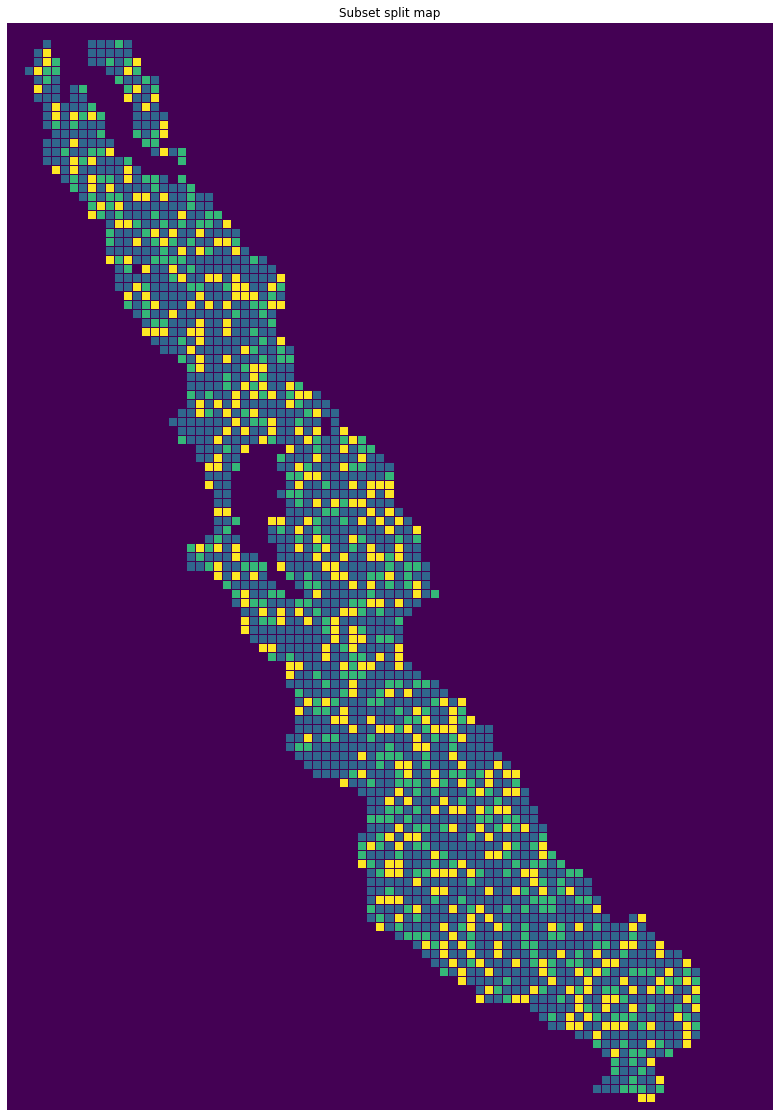

In [15]:
plt.figure(figsize=(20, 20))
plt.imshow(split_map)
plt.title(f'Subset split map')
plt.axis('off')
# plt.savefig(f'data/subset_split_map.png')
plt.show()